In [2]:
# Установка модулей
# pip install openpyxl
# pip install statsmodels
# pip install sklearn
# pip install tensorflow

# ARIMA MODEL

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error
import statsmodels.api as sm
from sklearn.metrics import r2_score
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from tensorflow.keras import optimizers

In [3]:
# Из исходных данных оставляем только дату(приводим ее к нужному формату) и температуру
df = pd.read_excel('данные_60_90.xlsx')
df = df[['дата','аномалии температуры']]
df['дата'] = pd.to_datetime(df['дата'])

In [4]:
# Рассматриваем только период с 1971 года
df = df.loc[df['дата']>'1970-12-01']
df = df.reset_index(drop=True)

In [5]:
df

,дата,аномалии температуры
0,1971-01-01,-0.662546
1,1971-02-01,-0.527617
2,1971-03-01,-0.085181
3,1971-04-01,-0.814122
4,1971-05-01,-0.373187
...,...,...
619,2022-08-01,1.443810
620,2022-09-01,1.292349
621,2022-10-01,1.444631
622,2022-11-01,1.136599


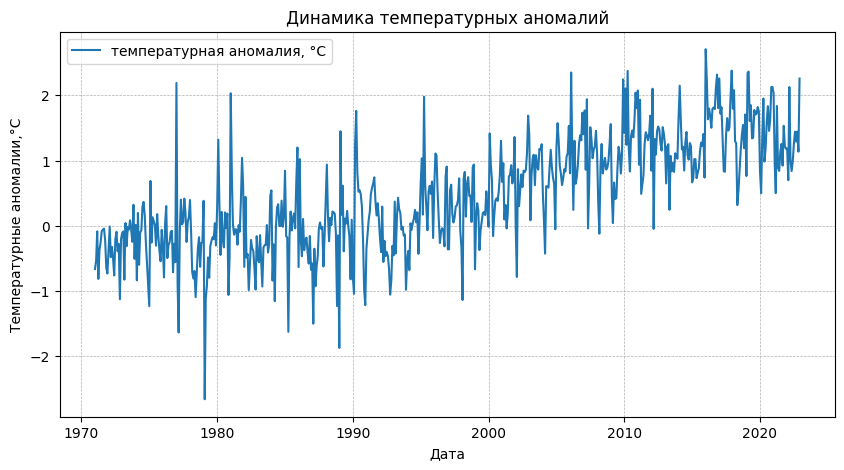

In [6]:
# Смотрим, что из себя представляют исходные данных
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.plot(df['дата'], df['аномалии температуры'])
plt.legend(('температурная аномалия, °С',''))
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии,°С')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

In [7]:
# Очевидно визиально, что ряд нестационарен, но нужен тест

# Тест Дики-Фулера:
# Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный
# Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным

result = adfuller(df['аномалии температуры'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# Ряд не стационарен - p-value гораздо выше 5% критического значения

ADF Statistic: -1.616962
p-value: 0.474322
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [8]:
# Тест kpss на стационарность
result = sm.tsa.stattools.kpss(df['аномалии температуры'], regression='ct')
print('Статистика теста KPSS: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
     print('\t%s: %.3f' % (key, value))
# Значение р равно 0.010000. Поскольку это значение меньше 0,05, мы отвергаем нулевую гипотезу теста KPSS
# Это означает, что временной ряд не имеет стационарного тренда

Статистика теста KPSS: 0.377816
p-value: 0.010000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Users\пользователь\AppData\Local\Temp\ipykernel_11208\4254124534.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = sm.tsa.stattools.kpss(df['аномалии температуры'], regression='ct')


In [9]:
# Приведение ряда к стационарности
df_diff = df.diff(periods=1).dropna()
df_diff['дата'] = df['дата'][1:]
df_diff

,дата,аномалии температуры
1,1971-02-01,0.134929
2,1971-03-01,0.442436
3,1971-04-01,-0.728941
4,1971-05-01,0.440935
5,1971-06-01,0.117367
...,...,...
619,2022-08-01,0.187347
620,2022-09-01,-0.151461
621,2022-10-01,0.152282
622,2022-11-01,-0.308032


In [10]:
# Повторные тесты
result = adfuller(df_diff['аномалии температуры'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.111789
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [11]:
# Тест kpss на стационарность
result = sm.tsa.stattools.kpss(df_diff['аномалии температуры'], regression='ct')
print('Статистика теста KPSS: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
     print('\t%s: %.3f' % (key, value))
# Настоящее значение даже больше, чем 0.100000 - ряд стационарен

Статистика теста KPSS: 0.024750
p-value: 0.100000
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Users\пользователь\AppData\Local\Temp\ipykernel_11208\892305680.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = sm.tsa.stattools.kpss(df_diff['аномалии температуры'], regression='ct')


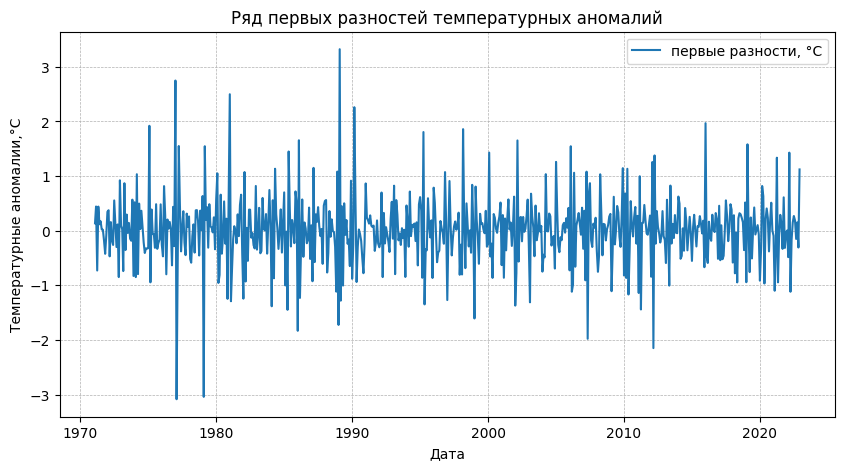

In [12]:
# Как выглядит ряд после приведения к стационарности
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.plot(df_diff['дата'], df_diff['аномалии температуры'])
plt.title('Ряд первых разностей температурных аномалий')
plt.legend(('первые разности, °С',''))
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии,°С')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()
# Тренд действительно отсутствует, таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка



Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA
Параметр d есть и он равет 1, осталось определить p и q. Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.

In [13]:
df_for_acf = df_diff['аномалии температуры']

Text(0, 0.5, 'Коэффициент корреляции')

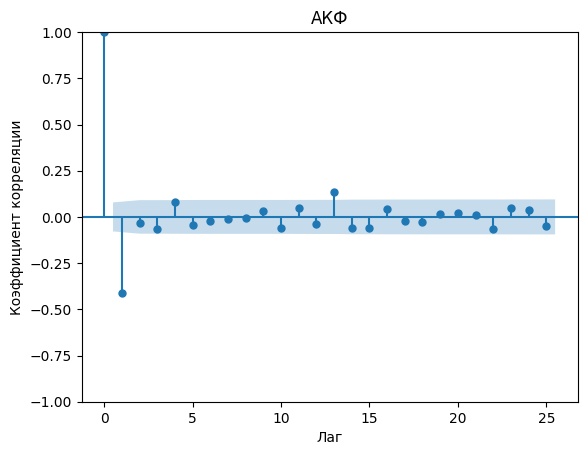

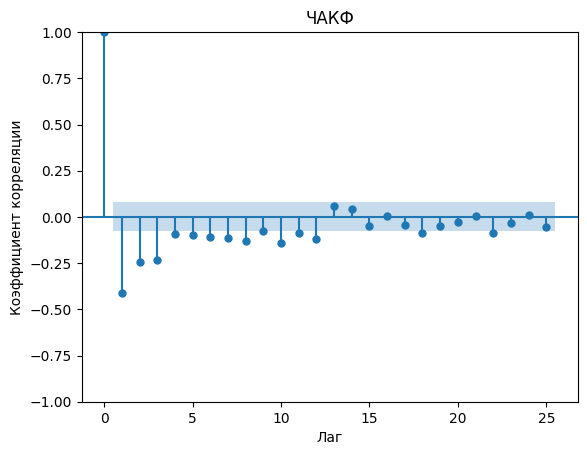

In [14]:
fig1 = sm.graphics.tsa.plot_acf(df_for_acf.values.squeeze(), lags=25)
fig1
plt.title('АКФ')
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')
fig2 = sm.graphics.tsa.plot_pacf(df_for_acf, lags=25)
plt.title('ЧАКФ')
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')


In [15]:
df_for_model = df.loc[df['дата']<='2021-12-01']
df_for_model['аномалии температуры'] = df_for_model['аномалии температуры'].astype(float)
df_for_model


C:\Users\пользователь\AppData\Local\Temp\ipykernel_11208\2419670329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_model['аномалии температуры'] = df_for_model['аномалии температуры'].astype(float)


,дата,аномалии температуры
0,1971-01-01,-0.662546
1,1971-02-01,-0.527617
2,1971-03-01,-0.085181
3,1971-04-01,-0.814122
4,1971-05-01,-0.373187
...,...,...
607,2021-08-01,1.255948
608,2021-09-01,0.922805
609,2021-10-01,1.532938
610,2021-11-01,1.217016


In [16]:
model = sm.tsa.ARIMA(df_for_model['аномалии температуры'], order=(1,1,1)).fit()

In [17]:
print(model.summary())

                                SARIMAX Results                                 
Dep. Variable:     аномалии температуры   No. Observations:                  612
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -468.966
Date:                  Sat, 11 May 2024   AIC                            943.932
Time:                          13:54:55   BIC                            957.178
Sample:                               0   HQIC                           949.084
                                  - 612                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2667      0.035      7.607      0.000       0.198       0.335
ma.L1         -0.9498      0.014    -66.360      0.000      -0.978      -0.922
sigma2         0.2710      0.010    

In [18]:
# Остатки модели
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.427908  0.513017
1    2.143956  0.342331
2    2.147274  0.542408
3    5.212089  0.266220
4    6.469917  0.263139
5    7.558915  0.272231
6    8.669839  0.277237
7    8.993485  0.342846
8    9.015378  0.435856
9    9.618564  0.474570
10  10.602599  0.477131
11  10.733122  0.551918
12  20.097948  0.092795
13  22.133343  0.075916
14  26.960006  0.029064
15  27.293991  0.038329
16  29.636817  0.029086
17  32.025350  0.021836
18  32.116206  0.030326
19  32.131228  0.041920
20  32.200249  0.055872
21  33.278267  0.058065
22  33.846905  0.067404
23  34.223885  0.080768
24  35.283326  0.083200
25  35.317806  0.104946
26  36.464885  0.105497


<AxesSubplot: >

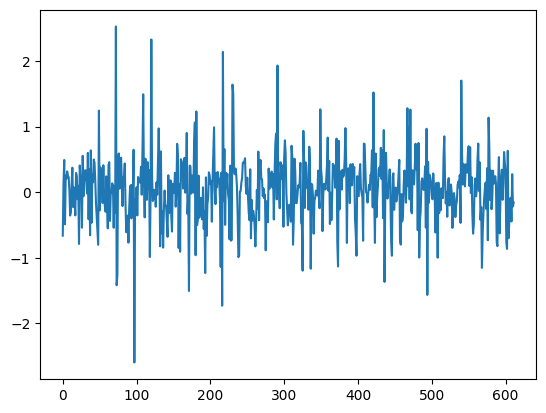

In [19]:
model.resid.plot()

In [20]:
# Данные для теста
df_test = df.loc[df["дата"] > '2021-12-01']
df_test = df_test['аномалии температуры']
df_test.reindex()
df_test

612    1.184358
613    0.699724
614    2.128165
615    1.010174
616    0.839705
617    0.987574
618    1.256463
619    1.443810
620    1.292349
621    1.444631
622    1.136599
623    2.257799
Name: аномалии температуры, dtype: float64

In [21]:
# результаты прогноза
forecast = model.get_forecast(steps=12).summary_frame(alpha=0.05)
forecast["дата"] = df['дата'].loc[df['дата']>'2021-12-01']
forecast

аномалии температуры,mean,mean_se,mean_ci_lower,mean_ci_upper,дата
612,1.321459,0.520539,0.301221,2.341697,2022-01-01
613,1.358951,0.546052,0.288710,2.429193,2022-02-01
614,1.368951,0.550535,0.289922,2.447980,2022-03-01
615,1.371618,0.552357,0.289019,2.454218,2022-04-01
616,1.372330,0.553668,0.287161,2.457499,2022-05-01
617,1.372520,0.554855,0.285024,2.460015,2022-06-01
618,1.372570,0.556008,0.282814,2.462326,2022-07-01
619,1.372584,0.557151,0.280587,2.464580,2022-08-01
620,1.372587,0.558290,0.278360,2.466815,2022-09-01
621,1.372588,0.559425,0.276135,2.469041,2022-10-01


In [22]:
forecast_mean = forecast['mean']

In [23]:
mse = mean_squared_error(df_test, forecast_mean)
mae = mean_absolute_error(df_test, forecast_mean)
r2 = r2_score(df_test, forecast_mean)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


MSE: 0.20514735686706087
MAE: 0.35794762738738073
R2: -0.008870577984460004


In [24]:
forecast_mean_data = pd.DataFrame()
forecast_mean_data['дата'] = forecast['дата']
forecast_mean_data['аномалии температуры'] = forecast['mean']
forecast_mean_data = forecast_mean_data.reset_index(drop=True)
forecast_mean_data


,дата,аномалии температуры
0,2022-01-01,1.321459
1,2022-02-01,1.358951
2,2022-03-01,1.368951
3,2022-04-01,1.371618
4,2022-05-01,1.372330
5,2022-06-01,1.372520
6,2022-07-01,1.372570
7,2022-08-01,1.372584
8,2022-09-01,1.372587
9,2022-10-01,1.372588


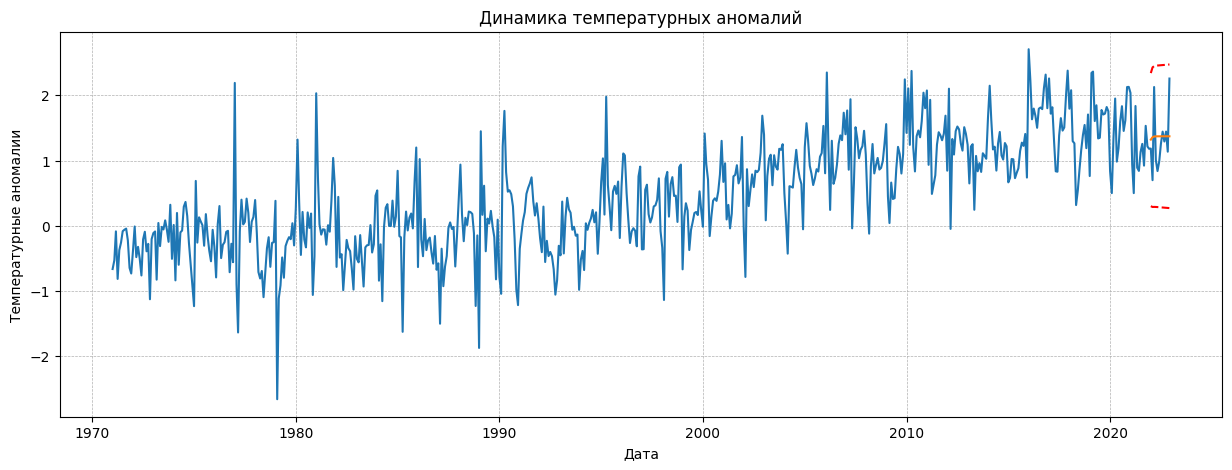

In [25]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.plot(df['дата'], df['аномалии температуры'])
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(forecast_mean_data['дата'], forecast_mean_data['аномалии температуры'])
plt.plot(forecast['дата'], forecast['mean_ci_lower'], '--', color='r')
plt.plot(forecast['дата'], forecast['mean_ci_upper'], '--', color='r')
plt.show()

# SARIMA MODEL


In [27]:
#  Используем готовую ARIMA модель и добавляем в нее сезоность

In [26]:
df

,дата,аномалии температуры
0,1971-01-01,-0.662546
1,1971-02-01,-0.527617
2,1971-03-01,-0.085181
3,1971-04-01,-0.814122
4,1971-05-01,-0.373187
...,...,...
619,2022-08-01,1.443810
620,2022-09-01,1.292349
621,2022-10-01,1.444631
622,2022-11-01,1.136599


In [102]:
model_2 = SARIMAX(df_for_model['аномалии температуры'], seasonal_order=(3, 1, 1, 12)).fit()
# Вывод статистики модели
print(model_2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                 аномалии температуры   No. Observations:                  612
Model:             SARIMAX(1, 0, 0)x(3, 1, [1], 12)   Log Likelihood                -498.192
Date:                              Sat, 11 May 2024   AIC                           1008.383
Time:                                      14:05:09   BIC                           1034.765
Sample:                                           0   HQIC                          1018.653
                                              - 612                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3235      0.031     10.369      0.000       0.262       0.385
ar.S.L12      -0.17

In [103]:
q_test = sm.tsa.stattools.acf(model_2.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    3.004834  0.083016
1    7.550601  0.022930
2    8.075390  0.044479
3   15.547414  0.003691
4   15.568232  0.008191
5   16.017680  0.013659
6   16.038010  0.024771
7   16.087719  0.041142
8   17.821677  0.037300
9   17.858448  0.057399
10  19.382683  0.054561
11  20.977595  0.050710
12  31.463674  0.002883
13  32.498885  0.003401
14  33.805437  0.003626
15  33.805532  0.005770
16  34.179431  0.007959
17  34.346425  0.011410
18  34.580338  0.015683
19  34.585903  0.022424
20  34.781640  0.029832
21  35.375969  0.035379
22  35.891748  0.042315
23  37.692098  0.037273
24  39.132648  0.035728
25  39.320694  0.045420
26  39.435939  0.057800


<AxesSubplot: >

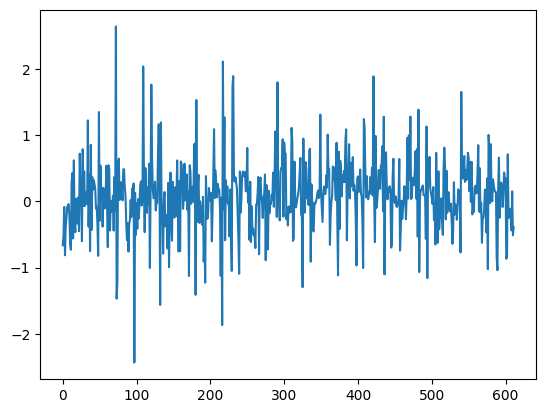

In [97]:
model_2.resid.plot()

In [104]:
# результаты прогноза
forecast_2 = model_2.get_forecast(steps=12).summary_frame(alpha=0.05)
forecast_2["дата"] = df['дата'].loc[df['дата']>'2021-12-01']
forecast_2

аномалии температуры,mean,mean_se,mean_ci_lower,mean_ci_upper,дата
612,1.381224,0.549398,0.304423,2.458024,2022-01-01
613,1.458181,0.577423,0.326453,2.589908,2022-02-01
614,1.355841,0.580276,0.218520,2.493161,2022-03-01
615,1.528930,0.580574,0.391026,2.666835,2022-04-01
616,0.971372,0.580605,-0.166593,2.109338,2022-05-01
617,0.969070,0.580609,-0.168902,2.107042,2022-06-01
618,1.259571,0.580609,0.121598,2.397543,2022-07-01
619,1.490915,0.580609,0.352943,2.628888,2022-08-01
620,1.371308,0.580609,0.233335,2.509280,2022-09-01
621,1.556920,0.580609,0.418948,2.694893,2022-10-01


In [33]:
forecast_2.to_csv("SARIMA.csv")

In [105]:
forecast2_mean = forecast_2['mean']

In [106]:
forecast_mean_data2 = pd.DataFrame()
forecast_mean_data2['дата'] = forecast_2['дата']
forecast_mean_data2['аномалии температуры'] = forecast_2['mean']
forecast_mean_data2 = forecast_mean_data2.reset_index(drop=True)
forecast_mean_data2


,дата,аномалии температуры
0,2022-01-01,1.381224
1,2022-02-01,1.458181
2,2022-03-01,1.355841
3,2022-04-01,1.528930
4,2022-05-01,0.971372
5,2022-06-01,0.969070
6,2022-07-01,1.259571
7,2022-08-01,1.490915
8,2022-09-01,1.371308
9,2022-10-01,1.556920


In [107]:
mse = mean_squared_error(df_test, forecast2_mean)
mae = mean_absolute_error(df_test, forecast2_mean)
r2 = r2_score(df_test, forecast2_mean)
mape = mean_absolute_percentage_error(df_test, forecast2_mean)
me = max_error(df_test, forecast2_mean)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'MAPE: {mape}')
print(f' ME: {me}')

MSE: 0.17402560208560033
MAE: 0.3086700099749285
R2: 0.14417951836461973
MAPE: 0.26400729463602196
 ME: 0.7723244399579292


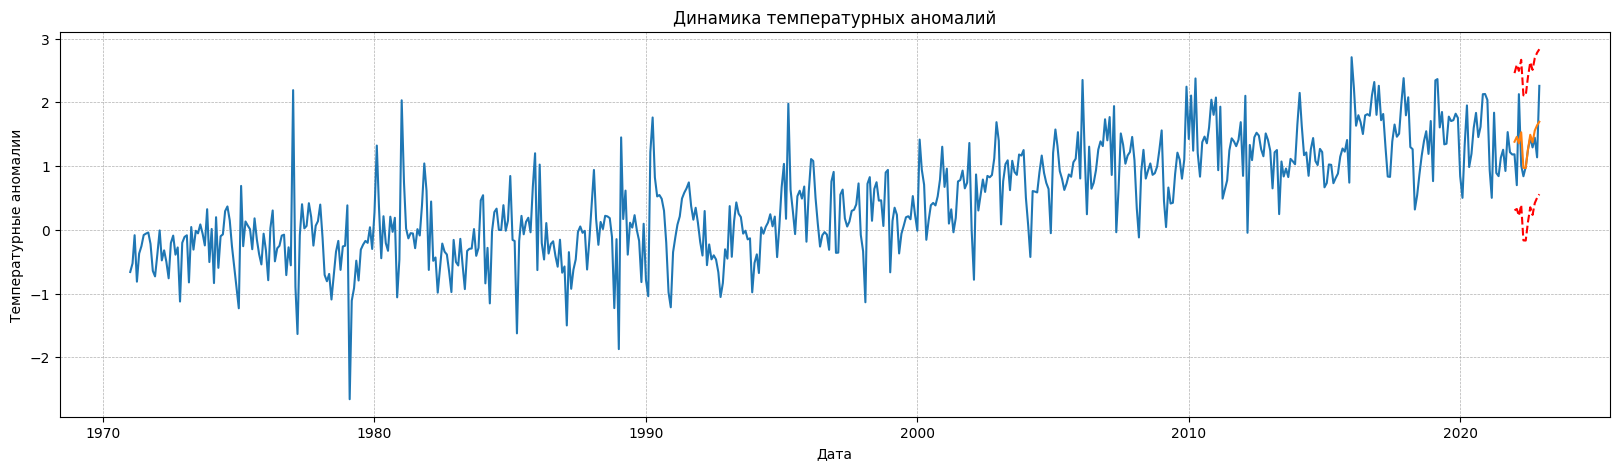

In [108]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
plt.plot(df['дата'], df['аномалии температуры'])
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(forecast_mean_data2['дата'], forecast_mean_data2['аномалии температуры'])
plt.plot(forecast_2['дата'], forecast_2['mean_ci_lower'], '--', color='r')
plt.plot(forecast_2['дата'], forecast_2['mean_ci_upper'], '--', color='r')
plt.show()

In [118]:
# Для наглядности
df1 = df.loc[df["дата"]> '2020-06-06']

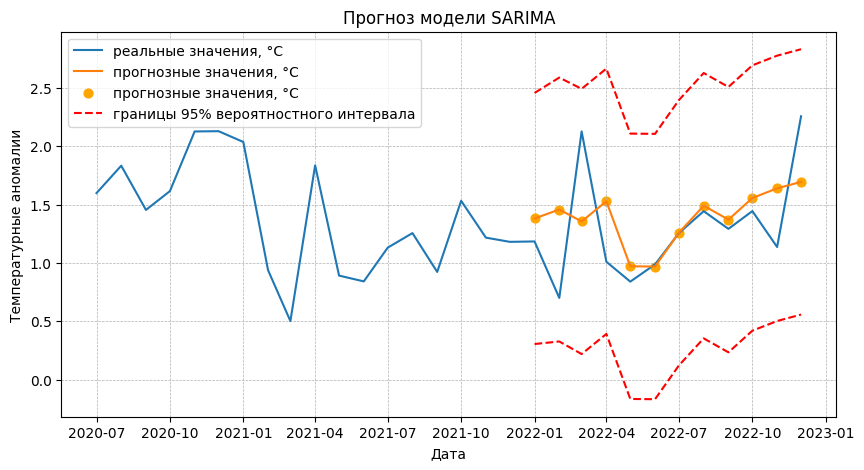

In [119]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.plot(df1['дата'], df1['аномалии температуры'])
plt.title('Прогноз модели SARIMA')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(forecast_mean_data2['дата'], forecast_mean_data2['аномалии температуры'])
plt.scatter(forecast_mean_data2['дата'],forecast_mean_data2['аномалии температуры'], color='orange', s=40, marker='o')
plt.plot(forecast_2['дата'], forecast_2['mean_ci_lower'], '--', color='r')
plt.plot(forecast_2['дата'], forecast_2['mean_ci_upper'], '--', color='r')
plt.legend(('реальные значения, °С','прогнозные значения, °С','прогнозные значения, °С','границы 95% вероятностного интервала',), loc='upper left')
# plt.axis([forecast_mean_data2['дата'].min(), forecast_mean_data2['дата'].max(), -0.5, 4])
plt.show()

## НЕЙРОННЫЕ СЕТИ


### МОДЕЛЬ №1 MLP

In [40]:
# Все данные в список
uni_data = df['аномалии температуры'].to_list()
len(uni_data)

624

In [41]:
# Данные для обучения - все кроме последнего года
uni_data_train = uni_data[:-12]
# Для теста - последний год
uni_data_test = uni_data[-12:]
print(len(uni_data_train))
print(len(uni_data_test))
# Для предсказания
uni_data_pred = uni_data[-36:-12]

612
12


In [42]:
# Функция для формирования массивов для обучения
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [43]:
# Размеры массивов - обучение и прогноз
n_steps_in, n_steps_out = 24, 12
X, y = split_sequence(uni_data_train, n_steps_in, n_steps_out)

# Сама модель
model = Sequential()
model.add(Dense(n_steps_in, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_steps_out))

opt = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mse')

model.fit(X, y, epochs=500, verbose=0)

x_input = array(uni_data_pred )
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [44]:
# Результаты прогноза в датафрейм
dfm1 = pd.DataFrame()
dfm1['data'] = df["дата"].loc[df["дата"]> '2021-12-01']
dfm1['temp'] = yhat[0]
dfm1

,data,temp
612,2022-01-01,1.401596
613,2022-02-01,1.006766
614,2022-03-01,0.871938
615,2022-04-01,1.047281
616,2022-05-01,1.032177
617,2022-06-01,1.218781
618,2022-07-01,1.275530
619,2022-08-01,1.612074
620,2022-09-01,1.620538
621,2022-10-01,1.607379


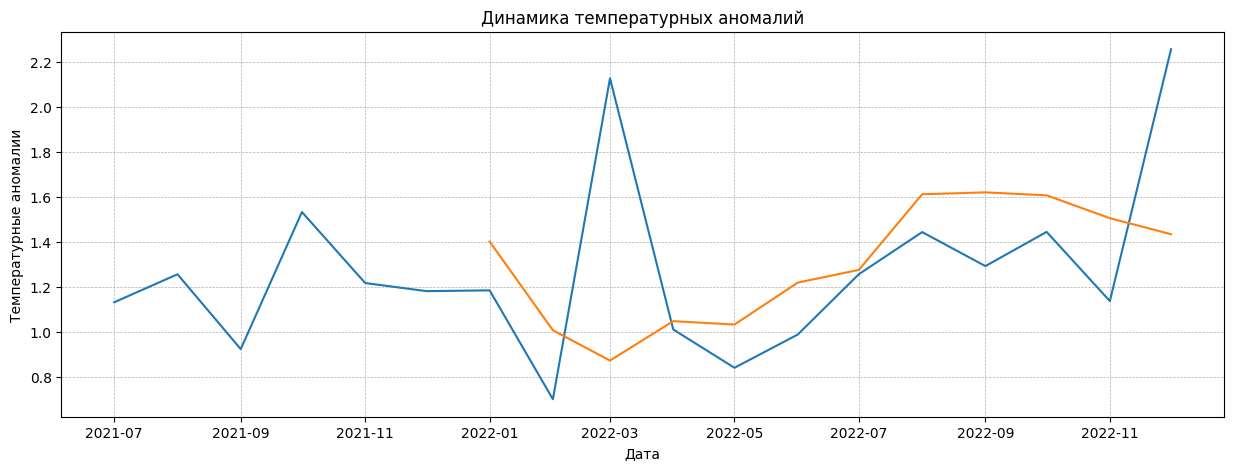

In [45]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.plot(df1['дата'], df1['аномалии температуры'])
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(dfm1['data'], dfm1['temp'])
plt.show()

In [46]:
mse = mean_squared_error(df_test, dfm1['temp'])
mae = mean_absolute_error(df_test, dfm1['temp'])
r2 = r2_score(df_test, dfm1['temp'])
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


MSE: 0.2323885263448852
MAE: 0.34267517374769846
R2: -0.14283679044643494


In [47]:
# Пробуем изменить параметры
# Размеры массивов - обучение и прогноз
n_steps_in, n_steps_out = 24, 12
X, y = split_sequence(uni_data_train, n_steps_in, n_steps_out)

# Сама модель
model = Sequential()
model.add(Dense(500, activation='selu', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=3000, verbose=0)

x_input = array(uni_data_pred)
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input, verbose=0)
print(yhat)

C:\Users\пользователь\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
# Результаты прогноза в датафрейм
dfm2 = pd.DataFrame()
dfm2['data'] = df["дата"].loc[df["дата"]> '2021-12-01']
dfm2['temp'] = yhat[0]

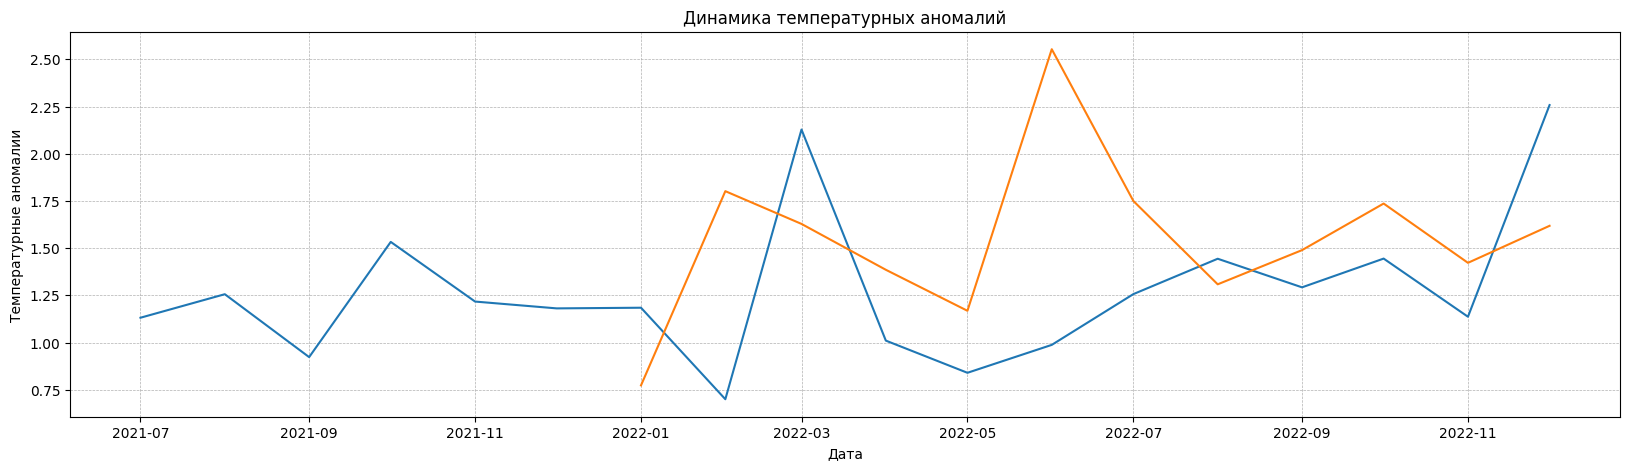

In [ ]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
plt.plot(df1['дата'], df1['аномалии температуры'])
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(dfm2['data'], dfm2['temp'])
plt.show()

In [ ]:
mse = mean_squared_error(df_test, dfm2['temp'])
mae = mean_absolute_error(df_test, dfm2['temp'])
r2 = r2_score(df_test, dfm2['temp'])
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


MSE: 0.43422236882356763
MAE: 0.5271145718008677
R2: -1.1354122173394314


In [ ]:
df_test

612    1.184358
613    0.699724
614    2.128165
615    1.010174
616    0.839705
617    0.987574
618    1.256463
619    1.443810
620    1.292349
621    1.444631
622    1.136599
623    2.257799
Name: аномалии температуры, dtype: float64

### Модель №2 1D CNN 

In [ ]:
n_steps_in, n_steps_out = 24, 12
X, y = split_sequence(uni_data_train, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=24, kernel_size=4, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=5000, verbose=0)
# demonstrate prediction
x_input = array(uni_data_pred)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

C:\Users\пользователь\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


[[1.3387187  1.3799739  1.4095197  0.88977623 1.17066    1.4038563
  1.6016366  1.435268   1.0584522  1.167364   1.2013526  2.0191603 ]]


In [ ]:
# Результаты прогноза в датафрейм
dfm3 = pd.DataFrame()
dfm3['data'] = df["дата"].loc[df["дата"]> '2021-12-01']
dfm3['temp'] = yhat[0]

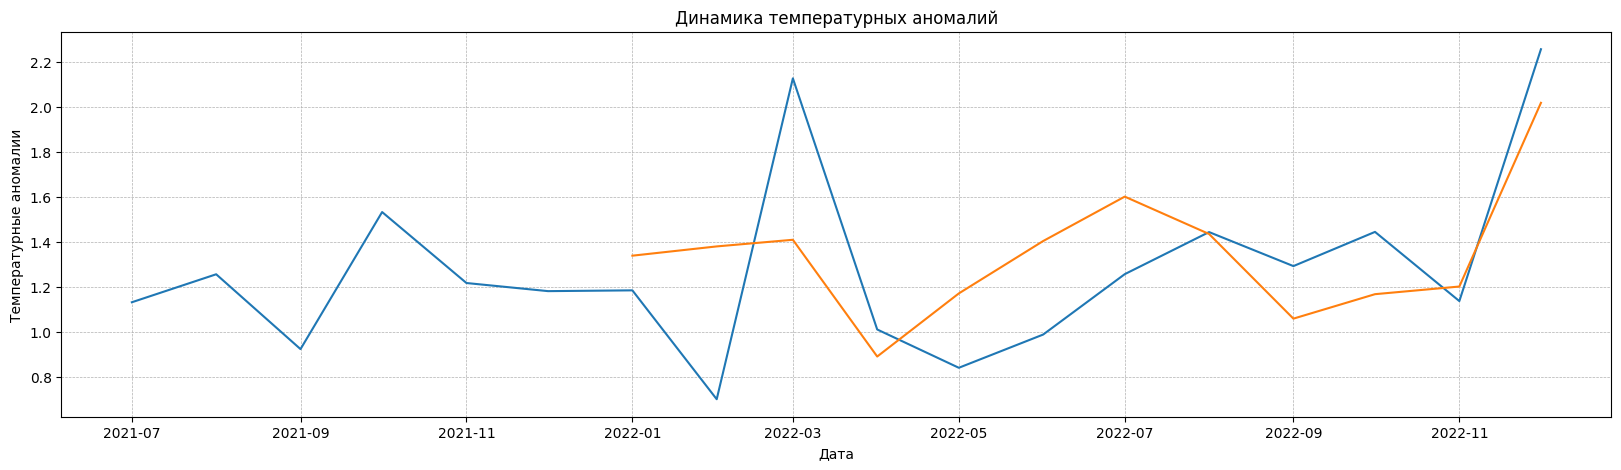

In [ ]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
plt.plot(df1['дата'], df1['аномалии температуры'])
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(dfm3['data'], dfm3['temp'])
plt.show()

In [ ]:
mse = mean_squared_error(df_test, dfm3['temp'])
mae = mean_absolute_error(df_test, dfm3['temp'])
r2 = r2_score(df_test, dfm2['temp'])
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 0.1343566644558016
MAE: 0.2990968845589956
R2: -1.1354122173394314


### Модель №3  LSTM

In [64]:

X, y = split_sequence(uni_data_train, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(LSTM(2000, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(2000, activation='relu'))

model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=15, verbose=1)

x_input = array(uni_data_pred)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Epoch 1/15


ValueError: Dimensions must be equal, but are 12 and 2000 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, sequential_11_1/lstm_21_1/strided_slice_3)' with input shapes: [?,12], [?,2000].

In [58]:
# Результаты прогноза в датафрейм
dfm4 = pd.DataFrame()
dfm4['data'] = df["дата"].loc[df["дата"]> '2021-12-01']
dfm4['temp'] = yhat[0]

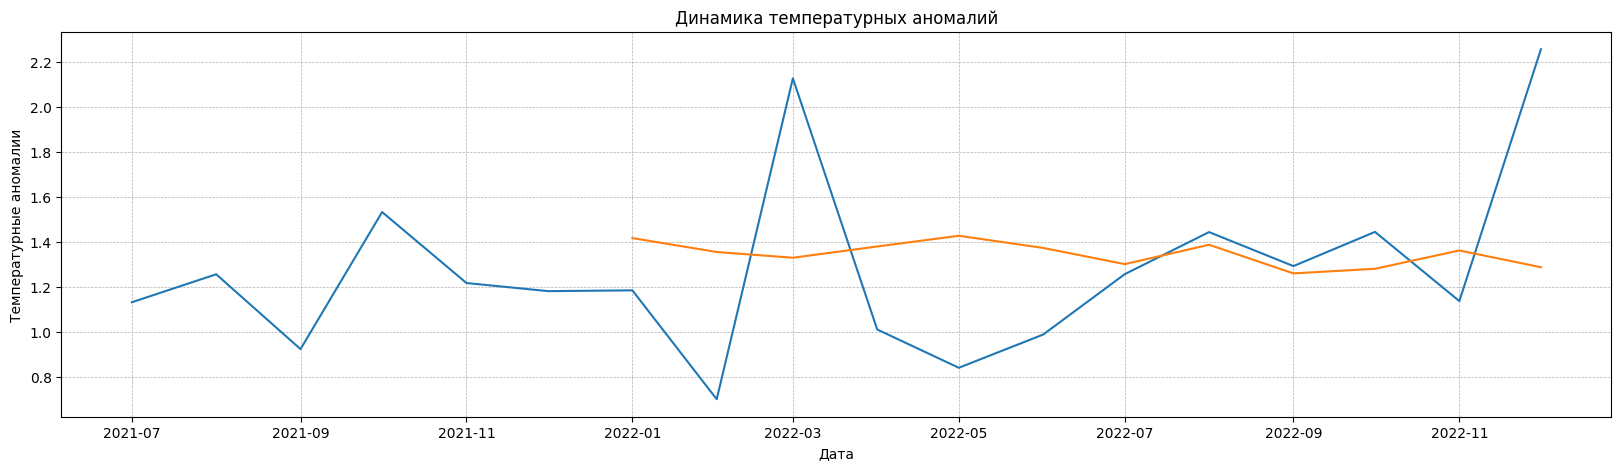

In [59]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
plt.plot(df1['дата'], df1['аномалии температуры'])
plt.title('Динамика температурных аномалий')
plt.xlabel('Дата')
plt.ylabel('Температурные аномалии')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot(dfm4['data'], dfm4['temp'])
plt.show()

In [56]:
mse = mean_squared_error(df_test, dfm4['temp'])
mae = mean_absolute_error(df_test, dfm4['temp'])
r2 = r2_score(df_test, dfm4['temp'])
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 0.22474048590582743
MAE: 0.37621147937647503
R2: -0.10522537250747144


In [ ]:
# Encoder-Decoder LSTM

In [ ]:
# X, y = split_sequence(uni_data_train, n_steps_in, n_steps_out)
# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# y = y.reshape((y.shape[0], y.shape[1], n_features))
# # define model
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(RepeatVector(n_steps_out))
# model.add(LSTM(100, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1)))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=100, verbose=0)
# # demonstrate prediction
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
# # Результаты прогноза в датафрейм
# dfm5 = pd.DataFrame()
# dfm5['data'] = df["дата"].loc[df["дата"]> '2021-12-01']
# dfm5['temp'] = yhat[0]

In [ ]:
# fig = plt.figure()
# fig.set_figheight(5)
# fig.set_figwidth(20)
# plt.plot(df1['дата'], df1['аномалии температуры'])
# plt.title('Динамика температурных аномалий')
# plt.xlabel('Дата')
# plt.ylabel('Температурные аномалии')
# plt.grid(linestyle = '--', linewidth = 0.5)
# plt.plot(dfm5['data'], dfm5['temp'])
# plt.show()

In [ ]:
# mse = mean_squared_error(df_test, dfm5['temp'])
# mae = mean_absolute_error(df_test, dfm5['temp'])
# r2 = r2_score(df_test, dfm2['temp'])
# print(f'MSE: {mse}')
# print(f'MAE: {mae}')
# print(f'R2: {r2}')